## Imports and set data path

In [1]:
# Imports
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

# Set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=sys.maxsize)
alt.data_transformers.disable_max_rows()


# Set data path here
data_path = 'airfoil_9k_data.h5'


## Explore contents and architecture of .h5 data file

`Data Structure` <br>
The .h5 data file is structured as follows: <br>

|-- root (group, 8997 members) <br>
 &emsp;&emsp;	|-- XXXX (group, 3 members) <br>
 &emsp;&emsp;	 &emsp;&emsp;	|-- alpha04 (group, 3 members) <br>
 &emsp;&emsp;	 &emsp;&emsp;	 &emsp;&emsp;	|-- C_d (dataset, shape()) <br>
 &emsp;&emsp;	 &emsp;&emsp;	 &emsp;&emsp;	|-- C_l (dataset, shape()) <br>
 &emsp;&emsp;	 &emsp;&emsp;	 &emsp;&emsp;	|-- C_m (dataset, shape()) <br>
 &emsp;&emsp;	 &emsp;&emsp;	|-- alpha12 (group, 3 members) <br>
 &emsp;&emsp;	 &emsp;&emsp;	 &emsp;&emsp;	|-- C_d (dataset, shape()) <br>
 &emsp;&emsp;	 &emsp;&emsp;	 &emsp;&emsp;	|-- C_l (dataset, shape()) <br>
 &emsp;&emsp;	 &emsp;&emsp;	 &emsp;&emsp;	|-- C_m (dataset, shape()) <br>
 &emsp;&emsp;	 &emsp;&emsp;	|-- shape (group, 4 members) <br>
 &emsp;&emsp;	 &emsp;&emsp;	&emsp;&emsp;	|-- bezier (dataset, shape(15,)) <br>
 &emsp;&emsp;	 &emsp;&emsp;	&emsp;&emsp;	|-- cst (dataset, shape(19,)) <br>
 &emsp;&emsp;	 &emsp;&emsp;	&emsp;&emsp;	|-- landmarks (dataset, shape(1001,2)) <br>
 &emsp;&emsp;	 &emsp;&emsp;	&emsp;&emsp;	|-- pga (dataset, shape(4,)) <br>



In [2]:
# Open file and print the top level group names/keys which correspond to unique airfoild shapes

# This data set contains 8997 unique airfoil shapes.
with h5py.File(data_path, 'r') as hf:
    af_names = [k for k in hf.keys()]
    print(af_names[:25], '...')


['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024'] ...


In [3]:
# Explore contents of the XXXX groups (first 3)

# Each XXXX airfoil group contains 3 groups:
# The shape group contains 4 members representing different paramerizations of the airfoil geometry:
#   The dataset "bezier" is a (15,) NumPy array representing the goemetry via a Bezier Curve
#   The dataset "cst" is a (19,) NumPy array representing the geometry via Class-Shape Transformation.
#   The dataset "landmarks" is a (1001, 2) NumPy array contain (x, y) landmarks describing the airfoil shape.
#   The dataset "pga" is a (4,) NumPy array representing the geometry via Principal Geodesic Analysis.
# The alpha04 and alpha12 groups contain aerodynamic flow quantities (lift, drag, and moment coefficients) computed at
# two angles of attack: alpha = 4 and alpha = 12 degrees.
with h5py.File(data_path, 'r') as hf:
    for name in af_names[0:3]:
        print('-------------------------------------------------')
        print('Group Name:', name)
        print('Group Info:', hf[name])
        print('')
        
        print('Members:\n')
        for key in list(hf[name].keys()):
            print(key)
            if 'alpha' in key:
                for key_aero in list(hf[name][key].keys()):
                    print('Aerodynamic quantities:')
                    print(hf[name][key][key_aero], '=', hf[name][key][key_aero][()])
            else:
                print('Airfoil shape data:')
                for key_shape in list (hf[name][key].keys()):
                    print(hf[name][key][key_shape])
            print('')
    print('-------------------------------------------------')
    

-------------------------------------------------
Group Name: 0000
Group Info: <HDF5 group "/0000" (3 members)>

Members:

alpha04
Aerodynamic quantities:
<HDF5 dataset "C_d": shape (), type "<f8"> = 0.009498384
Aerodynamic quantities:
<HDF5 dataset "C_l": shape (), type "<f8"> = 0.9502198
Aerodynamic quantities:
<HDF5 dataset "C_m": shape (), type "<f8"> = -0.09553732

alpha12
Aerodynamic quantities:
<HDF5 dataset "C_d": shape (), type "<f8"> = 0.0151438
Aerodynamic quantities:
<HDF5 dataset "C_l": shape (), type "<f8"> = 1.768766
Aerodynamic quantities:
<HDF5 dataset "C_m": shape (), type "<f8"> = -0.08837446

shape
Airfoil shape data:
<HDF5 dataset "bezier": shape (15,), type "<f8">
<HDF5 dataset "cst": shape (19,), type "<f8">
<HDF5 dataset "landmarks": shape (1001, 2), type "<f8">
<HDF5 dataset "pga": shape (4,), type "<f8">

-------------------------------------------------
Group Name: 0001
Group Info: <HDF5 group "/0001" (3 members)>

Members:

alpha04
Aerodynamic quantities:
<H

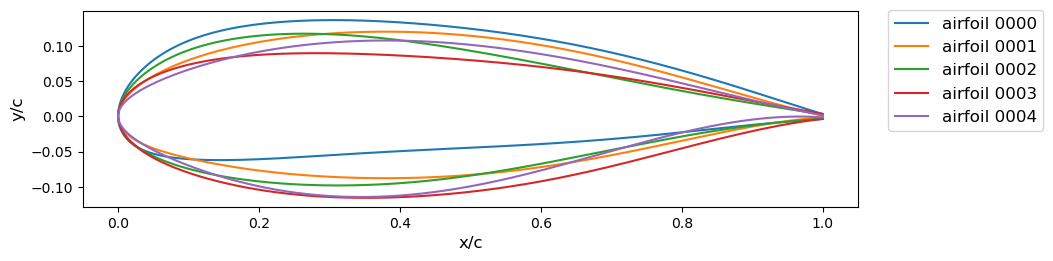

In [4]:
# Visualize the first 5 airfoil geometries using the landmark datasets
plt.figure(figsize=(10, 6))
with h5py.File(data_path, 'r') as hf:
    for name in af_names[0:5]:
        landmarks = hf[name]['shape']['landmarks'][()]
        plt.plot(landmarks[:, 0], landmarks[:, 1], label='airfoil {}'.format(name))
plt.xlabel('x/c', fontsize=12)
plt.ylabel('y/c', fontsize=12)
plt.gca().set_aspect(1.)
plt.legend(bbox_to_anchor=(1.25, 1.05), fontsize=12)
plt.show()

In [59]:
# Parse the landmark datasets and extract thickness along the chord and camber line along the chord
thickness_list = []
max_thick_camb_list = []
with h5py.File(data_path, 'r') as hf:
    for name in af_names:
        af_lm_temp = hf[name]['shape']['landmarks'][()]
        thickness_temp = abs(af_lm_temp[501:,1] - np.flip(af_lm_temp[:500,1],axis=0))
        camber_temp = (af_lm_temp[501:,1] + np.flip(af_lm_temp[:500,1],axis=0))/2
        thickness_list.extend([list(a) for a in zip([round(i,3) for i in np.arange(0.002,1.002,0.002)],thickness_temp,camber_temp)])
        max_thick_camb_list.append([thickness_temp.max(), camber_temp.max()])

df_thickness = pd.DataFrame(thickness_list, columns=['x/c','thickness/c','camber/c'])
max_thick_camb_arr = np.array(max_thick_camb_list)

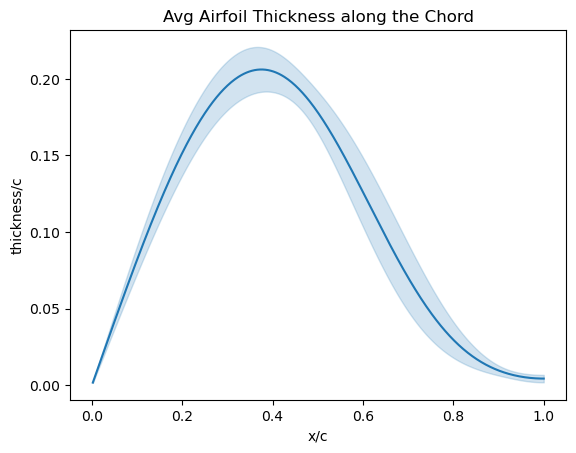

In [77]:
# Visualize average thickness along the chord and standard deviation across airfoils
ax = sns.lineplot(data=df_thickness, x='x/c', y='thickness/c', errorbar='sd', n_boot=(len(df_thickness)*0.60))
ax.set_title('Avg Airfoil Thickness along the Chord');

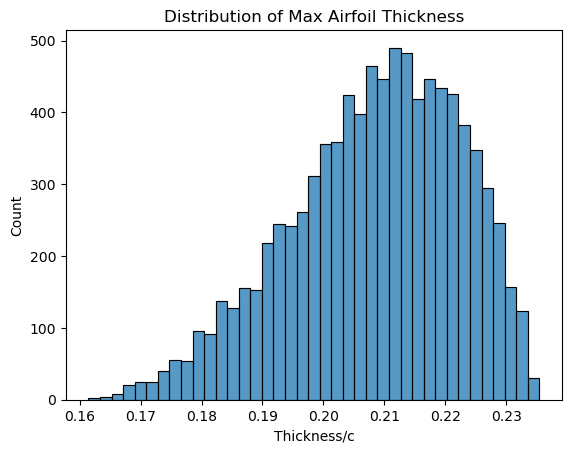

In [78]:
# Visualize distribution of maximum thickness across airfoils
ax = sns.histplot(data=max_thick_camb_arr[:,0], stat='count')
ax.set_title('Distribution of Max Airfoil Thickness')
ax.set(xlabel='Thickness/c');

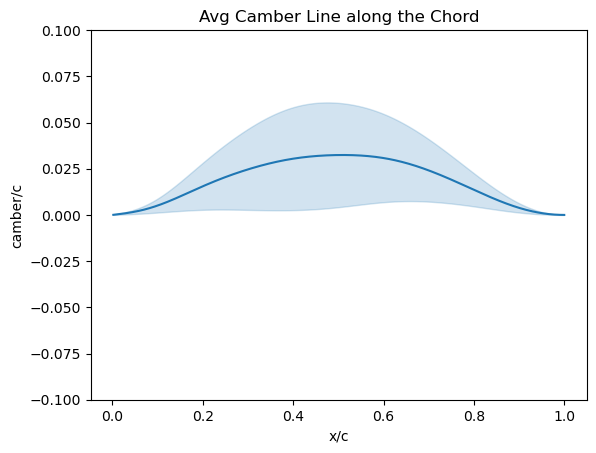

In [79]:
# Visualization of Average Camber line and standard deviation across airfoils
ax = sns.lineplot(data=df_thickness, x='x/c', y='camber/c', errorbar='sd', n_boot=(len(df_thickness)*0.60))
ax.set_title('Avg Camber Line along the Chord')
ax.set_ylim(ymin=-0.10, ymax=0.10);

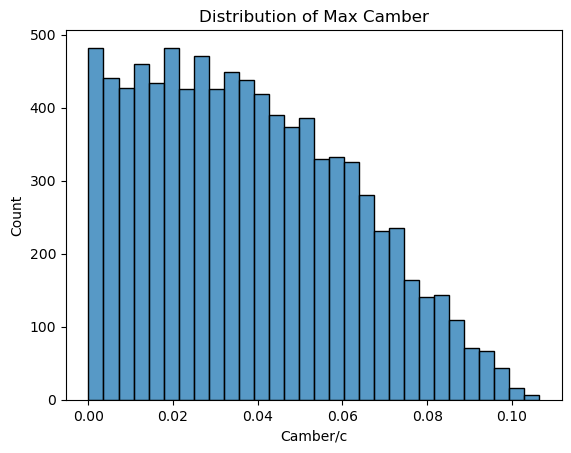

In [80]:
# Visualize distribution of maximum camber across airfoils
ax = sns.histplot(data=max_thick_camb_arr[:,1], stat='count')
ax.set_title('Distribution of Max Camber')
ax.set(xlabel='Camber/c');

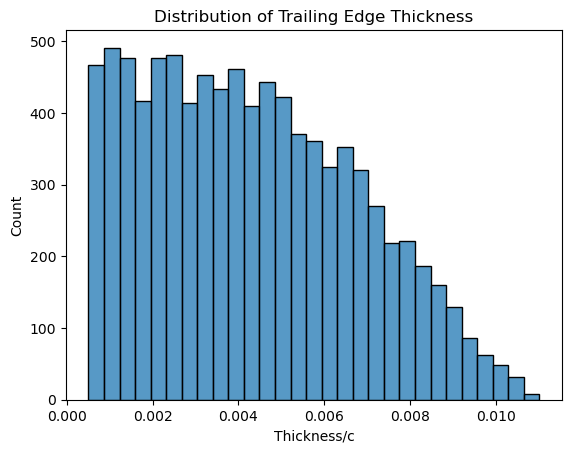

In [94]:
ax = sns.histplot(data=df_thickness[df_thickness['x/c']==1.0]['thickness/c'], stat='count')
ax.set_title('Distribution of Trailing Edge Thickness')
ax.set(xlabel='Thickness/c');

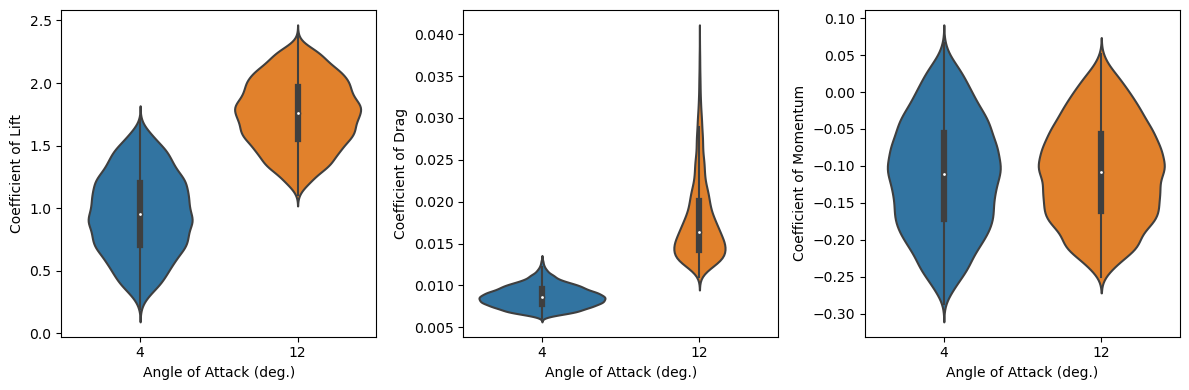

In [24]:
cl_alpha04, cd_alpha04, cm_alpha04 = [], [], []
cl_alpha12, cd_alpha12, cm_alpha12 = [], [], []
with h5py.File(data_path, 'r') as hf:
    for name in af_names:
        cl_alpha04.append(hf[name]['alpha04']['C_l'][()])
        cd_alpha04.append(hf[name]['alpha04']['C_d'][()])
        cm_alpha04.append(hf[name]['alpha04']['C_m'][()])
        
        cl_alpha12.append(hf[name]['alpha12']['C_l'][()])
        cd_alpha12.append(hf[name]['alpha12']['C_d'][()])
        cm_alpha12.append(hf[name]['alpha12']['C_m'][()])

plt.figure(figsize=(12, 4))

plt.subplot(131)
ax = sns.violinplot(data=[cl_alpha04, cl_alpha12])
ax.set_xticklabels([4,12])
plt.xlabel('Angle of Attack (deg.)')
plt.ylabel('Coefficient of Lift')

plt.subplot(132)
ax = sns.violinplot(data=[cd_alpha04, cd_alpha12])
ax.set_xticklabels([4,12])
plt.xlabel('Angle of Attack (deg.)')
plt.ylabel('Coefficient of Drag')

plt.subplot(133)
ax = sns.violinplot(data=[cm_alpha04, cm_alpha12])
ax.set_xticklabels([4,12])
plt.xlabel('Angle of Attack (deg.)')
plt.ylabel('Coefficient of Momentum')

plt.tight_layout()
plt.show()